In [1]:
!pip install torchsummary

In [2]:
# import packages
import os
import pickle
from tqdm.notebook import tqdm
import random
from tabulate import tabulate
from torchsummary import summary
from PIL import Image
import timm

import cv2
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as t

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torchvision import models
from torchvision.transforms.v2 import Resize, Compose, RandomHorizontalFlip, ColorJitter, RandomAffine, RandomErasing, ToTensor

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
tr_test = pd.read_csv('/kaggle/input/kidney-dat/kidney.csv')
X = list(tr_test['Paths'])
y = list(tr_test['labels'])

In [4]:
train_transforms = Compose([
                            Resize((224, 224), antialias = True),
                            RandomHorizontalFlip(),  # Randomly flip images left-right
                            ColorJitter(brightness=0.2),  # Randomly adjust brightness
#                             ColorJitter(contrast=0.2),  # Randomly adjust contrast
#                             RandomAffine(degrees=0, shear=10),  # Apply shear transformation
                            RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Apply zoom transformation
                            RandomErasing(p=0.2, scale=(0.02, 0.2)), # Coarse dropout
                            ToTensor(),
                        ])
test_transforms = Compose([
                            Resize((224, 224), antialias = True),
#                             RandomHorizontalFlip(),  # Randomly flip images left-right
#                             ColorJitter(brightness=0.2),  # Randomly adjust brightness
#                             ColorJitter(contrast=0.2),  # Randomly adjust contrast
# #                             RandomAffine(degrees=0, shear=10),  # Apply shear transformation
#                             RandomAffine(degrees=0, scale=(0.9, 1.1)),  # Apply zoom transformation
#                             RandomErasing(p=0.2, scale=(0.02, 0.2)), # Coarse dropout
                            ToTensor(),
                        ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [5]:
img = Image.open(tr_test['Paths'][0]).convert('RGB')

In [6]:
# dataset
class KidneyData(Dataset):
    
    def __init__(self, paths, labels, transform=None):
        
        super().__init__()                
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):

        path = self.paths[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
                
        label = self.labels[idx]
                
        
        return {
            'image': img,
            'label':label,
        }

In [7]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [8]:
train_data = KidneyData(train_X,train_y,train_transforms)
val_data = KidneyData(test_X,test_y,test_transforms)

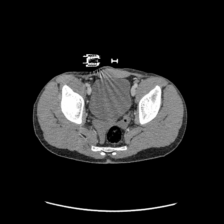

In [9]:
a = next(iter(val_data))
transform = t.ToPILImage()
img = transform(a['image'])
display(img)

In [10]:
model = timm.create_model('resnet18d', pretrained=False)

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = timm.create_model('resnet18d', pretrained=False)
        model.fc = nn.Sequential(
                nn.Linear(in_features=512, out_features=100, bias=True),
                nn.BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
        )
        self.model = model
        self.fin = nn.Linear(100, 1)
        
    def forward(self, x):
        
        # extract features
        x = self.model(x)
        
        # output logits
        out = self.fin(x)

        return out

In [12]:
model = CNNModel().to('cuda')

In [13]:
BATCH_SIZE = 128
NUM_EPOCHS = 25
LR = 3e-5

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
bce = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3.0]).to('cuda'))
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

In [15]:
train_dataloader = DataLoader(train_data,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_data,batch_size = BATCH_SIZE, shuffle = False)

In [16]:
class MetricsCalculator:
    
    def __init__(self, mode = 'binary'):
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
        
        self.mode = mode
    
    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.
        
        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        if self.mode == 'binary':
            probabilities = torch.sigmoid(logits)
            predicted = (probabilities > 0.5)
        else:
            probabilities = F.softmax(logits, dim = 1)
            predicted = torch.argmax(probabilities, dim=1)
            
        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())
    
    def reset(self):
        """Reset the stored predictions and targets."""
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
    
    def compute_accuracy(self):
        """
        Compute the accuracy metric.
        
        Returns:
            float: Accuracy.
        """
        return accuracy_score(self.targets, self.predictions)
    
    def compute_f1(self):
        return f1_score(self.targets, self.predictions)
    
    def compute_auc(self):
        """
        Compute the AUC (Area Under the Curve) metric.
        
        Returns:
            float: AUC.
        """
        if self.mode == 'multi':
            return roc_auc_score(self.targets, self.probabilities, multi_class = 'ovo', labels=[0, 1, 2])
    
        else:
            return roc_auc_score(self.targets, self.probabilities)

In [17]:
train_acc = MetricsCalculator('binary')
val_acc = MetricsCalculator('binary')


In [18]:
prev_val_best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    train_loss = 0.0
    val_loss = 0.0
    
    print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}]')
        
    for batch_idx, batch_data in enumerate(tqdm(train_dataloader)):
        
        inputs = batch_data['image'].to('cuda')
        label = batch_data['label'].to('cuda')
        
        optimizer.zero_grad()
        out = model(inputs)
        loss = bce(out, label.float().unsqueeze(1))
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        train_acc.update(out, label)
    
    train_loss = train_loss/(batch_idx+1)
    
    # validation
    model.eval()
    running_loss = 0.0
    
    for batch_idx, batch_data in enumerate(tqdm(val_dataloader)):
                                                
        inputs = batch_data['image'].to('cuda')
        label = batch_data['label'].to('cuda')

        
        out = model(inputs)
        loss = bce(out, label.float().unsqueeze(1))
        
        
        val_loss += loss.item()
        val_acc.update(out, label)    
    
    val_loss = val_loss/(batch_idx+1)
    scheduler.step(val_loss)
    
    if val_loss < prev_val_best_loss:
        prev_val_best_loss = val_loss
        print("Validation Loss improved, Saving Model...")
        torch.save(model, f'best_resnet_18d_kiddet.pth')
    if (epoch%5)==0:   
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'train_loss':train_loss,
            'val_loss':val_loss,
            }, f'checkpoint_{epoch}_resnet_18_kiddet.pth')

    
    
    # accuracy and auc data
    metrics_data = [
                    ["Kidney", 
                        train_acc.compute_accuracy(),
                        val_acc.compute_accuracy(),
                        train_acc.compute_auc(),
                        val_acc.compute_auc(),
                        train_acc.compute_f1(),
                        val_acc.compute_f1()]
                ]
    
    # verbose
    print('')
    print(tabulate(metrics_data, headers=["", "Train Acc", "Val Acc", "Train AUC", "Val AUC","Train F1","Val F1"]))
    
    print(f'\nMean Train Loss: {train_loss:.3f}')
    print(f'Mean Val Loss: {val_loss:.3f}\n')
    
    #reset metrics
    train_acc.reset()
    val_acc.reset()


Epoch: [1/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.657685   0.752656     0.748083   0.580435    0.511376         0

Mean Train Loss: 0.939
Mean Val Loss: 1.016

Epoch: [2/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.716509   0.752656     0.892068   0.734663    0.613154         0

Mean Train Loss: 0.790
Mean Val Loss: 1.002

Epoch: [3/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.760911   0.798179     0.933687   0.859576    0.662017  0.344828

Mean Train Loss: 0.695
Mean Val Loss: 0.874

Epoch: [4/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.792789   0.893778     0.952795   0.979529    0.695652  0.818653

Mean Train Loss: 0.627
Mean Val Loss: 0.530

Epoch: [5/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.821252   0.825493     0.964374   0.979938    0.730703  0.739229

Mean Train Loss: 0.569
Mean Val Loss: 0.519

Epoch: [6/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.854269   0.843703      0.97903   0.988188    0.769508  0.759907

Mean Train Loss: 0.509
Mean Val Loss: 0.492

Epoch: [7/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.874383   0.966616     0.986384    0.99791    0.796808  0.936782

Mean Train Loss: 0.469
Mean Val Loss: 0.353

Epoch: [8/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.887666   0.962064     0.990633   0.999753     0.81407  0.928775

Mean Train Loss: 0.428
Mean Val Loss: 0.325

Epoch: [9/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.908918   0.951442     0.994934   0.999975     0.84375  0.910615

Mean Train Loss: 0.388
Mean Val Loss: 0.303

Epoch: [10/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.935104   0.966616     0.996781   0.999975    0.883753  0.936782

Mean Train Loss: 0.348
Mean Val Loss: 0.271

Epoch: [11/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.949146   0.962064     0.998647          1    0.906555  0.928775

Mean Train Loss: 0.319
Mean Val Loss: 0.254

Epoch: [12/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.958254    0.91654     0.998325          1    0.921986  0.855643

Mean Train Loss: 0.302
Mean Val Loss: 0.311

Epoch: [13/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.963947   0.971168     0.999687          1    0.932094  0.944928

Mean Train Loss: 0.269
Mean Val Loss: 0.261

Epoch: [14/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.967362   0.975721     0.999257          1    0.937861  0.953216

Mean Train Loss: 0.257
Mean Val Loss: 0.206

Epoch: [15/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.981025   0.995448     0.999675          1    0.963018  0.990881

Mean Train Loss: 0.236
Mean Val Loss: 0.160

Epoch: [16/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.976091   0.990895     0.999698          1    0.953914  0.981928

Mean Train Loss: 0.226
Mean Val Loss: 0.167

Epoch: [17/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.979886    0.98786     0.999515          1    0.960712  0.976048

Mean Train Loss: 0.212
Mean Val Loss: 0.175

Epoch: [18/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.986717   0.998483     0.999831          1    0.973822  0.996942

Mean Train Loss: 0.199
Mean Val Loss: 0.140

Epoch: [19/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.988615          1     0.999858          1    0.977477         1

Mean Train Loss: 0.186
Mean Val Loss: 0.129

Epoch: [20/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.991651   0.989378      0.99991          1    0.983409  0.978979

Mean Train Loss: 0.179
Mean Val Loss: 0.162

Epoch: [21/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.991271          1     0.999855          1    0.982615         1

Mean Train Loss: 0.177
Mean Val Loss: 0.135

Epoch: [22/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.993928   0.990895      0.99992          1    0.987842  0.981928

Mean Train Loss: 0.165
Mean Val Loss: 0.145

Epoch: [23/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Validation Loss improved, Saving Model...

          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.987476   0.992413     0.999558          1    0.975207  0.984894

Mean Train Loss: 0.170
Mean Val Loss: 0.126

Epoch: [24/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.993928   0.995448     0.999963          1    0.987879  0.990881

Mean Train Loss: 0.155
Mean Val Loss: 0.132

Epoch: [25/25]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


          Train Acc    Val Acc    Train AUC    Val AUC    Train F1    Val F1
------  -----------  ---------  -----------  ---------  ----------  --------
Kidney     0.994687   0.989378     0.999887          1    0.989362  0.978979

Mean Train Loss: 0.150
Mean Val Loss: 0.142

